<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Poverty Prediction</h1> 
<h2 style="text-align: center;" markdown="2">A project of the World Bank's Knowledge for Change Program</h2>
<h3 style="text-align: center;" markdown="3">(KCP, Grant TF0A4534)</h3>


> *This notebook is part of a series that has been developed as an empirical comparative assessment of machine learning classification algorithms applied to poverty prediction. The objectives of this project are to explore how well machine learning algorithms perform when given the task to identify the poor in a given population, and to provide a resource of machine learning techniques for researchers, data scientists, and statisticians in developing countries.*

<h1 style="text-align: center;" markdown="3">Algorithm Comparative Assessment</h1> 
<h2 style="text-align: center;" markdown="3">Part 2: Indonesia Poverty Prediction</h2> 

# Table of Contents
[Introduction](#introduction)  
[Data Setup](#data-setup)  
[Model Results using Simple Feature Set](#simple)  
[Model Results using Full Feature Set](#full)  
[Model Results including Class Balancing, Tuning, CV, and Feature Selection](#all)  
[Summary](#summary)



# Introduction <a class="anchor" id="introduction"></a>

Now that we have implemented all ten algorithms, we can bring all the results together for a final comparative assessment. As we compare the performance of these classifiers, there are a few things to keep in mind:
* Each algorithm has specific benefits and drawbacks. Though we are making a quantitative assessment based on several metrics, there are tradeoffs that should be considered, such as which metric we are most concerned with in a particular scenario, computational efficiency, and the ability to rank and select features.
* Though we demonstrate feature tuning and some model augmentation techniques for each algorithm, this project does not seek to find the optimum implementation of each model. It is very likely that with more detailed model development and feature engineering, certain algorithms could reach a higher level of performance on this dataset. We only seek to build a baseline comparison in this project.

# Data Setup <a class="anchor" id="data-setup"></a>

All of our model results are stored in the `models` directory and in their respective country folder. To compare results, we have built a few helpful functions within the `evaluation` and `visualization` directories that will help us load the models we want to compare and plot their metrics.

In [1]:
%matplotlib inline

import os
from pathlib import Path
import sys
import json
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from visualization import visualize
from data.load_data import (get_country_filepaths, 
                            split_features_labels_weights, 
                            load_data)
from features.process_features import get_vif, standardize
from features.process_features import MWI_BASIC_FEATURES

COUNTRY = 'idn'
TRAIN_PATH, TEST_PATH, QUESTIONS_PATH = get_country_filepaths(COUNTRY)

# load text of survey questions for reference
with open(QUESTIONS_PATH, 'r') as fp:
    questions = json.load(fp)

Using TensorFlow backend.


In [2]:
%load_ext autoreload
%autoreload 1
%aimport models.evaluation
%aimport visualization.visualize

# Model Results using Simple Feature Set <a class="anchor" id="simple"></a>

We'll begin by comparing the results of all models using the simple feature set. To give a basic idea of model rank, we rank each model metric from best to worst and take the average across all metrics. 

This gives us a general idea of how the default models perform using only a small subset of features for this problem.

In [3]:
# set allowed model names (nothing from later notebooks)
allowed_models = ['svm', 'xgb', 'lr', 'nb', 'rf',
                  'dl', 'mlp', 'lda', 'dt', 'knn']

In [4]:
files = os.listdir(os.path.join(evaluation.MODELS_DIR, COUNTRY))
models = [f[:-4] for f in files if f[-4:] == '.pkl']
models = [f for f in models if f[-6:] == 'simple']

# only include models from prior notebooks
models = [f for allowed in allowed_models for f in models if allowed in f]

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samp

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa,pov_rate_error,mean_rank
lda_simple,0.907176,0.16531,0.45913,0.243094,0.26302,0.779387,0.205146,-0.0818048,3.25
lr_simple,0.91158,0.0851597,0.564315,0.147987,0.256817,0.781848,0.127352,-0.100128,3.375
mlp_simple,0.911919,0.0626174,0.613497,0.113636,0.254315,0.786015,0.0985809,-0.107941,3.5
xgb_simple,0.911411,0.053851,0.597222,0.0987938,0.256817,0.782269,0.0851478,-0.107761,4.5
dt_simple,0.902377,0.12774,0.377778,0.190922,1.32187,0.657529,0.152292,-0.0817502,5.375
rf_simple,0.900909,0.117721,0.35206,0.176443,0.616494,0.705691,0.137464,-0.0785157,5.5
nb_simple,0.906838,0.0670006,0.400749,0.114807,0.275322,0.734987,0.0913343,-0.10089,5.75
knn_simple,0.910282,0.0269255,0.551282,0.0513433,0.818091,0.710226,0.0433091,-0.111192,7
dl_simple,0.90983,0,0,0,0.277978,0.7738,0,-0.113791,8.0625
svm_simple,0.90983,0,0,0,0.29088,0.604869,0,-0.113681,8.6875


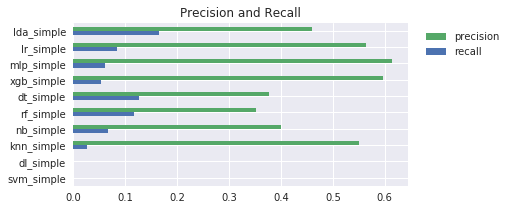

In [5]:
metrics = [evaluation.load_model_metrics(f, COUNTRY) for f in models]
results = visualize.display_model_comparison(metrics, 
                                             show_roc=False, 
                                             show_cm=False, 
                                             show_pov_rate_error=True, 
                                             highlight_best=True, 
                                             transpose=True, 
                                             rank_order=True)
visualize.display_precision_recall(results)

In the results above, it appears that the baseline Logistic Regression model gives us the highest average performance across metrics. However, it has a very low recall level, which we expect since we did not apply any class balancing to the simple models. The default LDA model appears to give us at least some level of recall, but it is too low to realistically be useful.

Since several models give us some idea of feature importance or ranking, we can also to evaluate which features are most influential across models. We use a similar ranking method as with the metrics, where we'll take the models that give us a quantitative ranking and average the rank across all. 

As a reminder, the following models gave us an idea of feature ranking, either by the coefficients or the feature importances:

Model | abs(coef*stdev) | feature importance
--- | ---
Logistic Regression | ✓ | 
LDA | ✓ |
KNN | | 
Naive Bayes | |
SVM | |
Decision Trees | | ✓
Random Forests | | ✓
XGBoost | | ✓
MLP | | 
Deep Learning | |

In [6]:
feats = evaluation.load_feats(models, COUNTRY)
visualize.display_feat_ranks(feats);

,dt_simple,lda_simple,lr_simple,rf_simple,xgb_simple,mean_rank,count
der_nliterate,1,1,1,1,2,1.2,5
der_nchild10under,3,4,3,3,1,2.8,5
der_nfemalesover10,5,2,2,5,3,3.4,5
der_nmalesover10,4,3,4,4,4,3.8,5
der_nemployedpast3mo,2,8,9,2,5,5.2,5
hld_toilet__None,6,6,5,6,6,5.8,5
hld_lighting__PLN electricity,7,5,7,7,7,6.6,5
cons_029__Yes,8,7,8,8,8.5,7.9,5
cons_054__Yes,9,9,6,9,8.5,8.3,5


# Model Results using Full Feature Set <a class="anchor" id="full"></a>

Now let's examine how the models performed with default settings on the full feature set. 

In [7]:
files = os.listdir(os.path.join(evaluation.MODELS_DIR, COUNTRY))
models = [f[:-4] for f in files if f[-4:] == '.pkl']
models = [f for f in models if f[-len('full'):] == 'full']

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa,pov_rate_error,mean_rank
lr_full,0.910251,0.456232,0.661838,0.540131,0.212947,0.923198,0.483497,-0.0313397,2.125
mlp_full,0.905157,0.478638,0.615018,0.538325,0.546706,0.919996,0.520722,-0.0072533,3.125
lda_full,0.905845,0.405497,0.647748,0.498763,0.231353,0.911848,0.456538,-0.0408086,3.875
xgb_full,0.898412,0.184368,0.74314,0.295439,0.22428,0.917406,0.284804,-0.0822224,5
nb_full,0.807276,0.603248,0.321776,0.419688,1.89316,0.827704,0.238088,0.0984808,6.25
svm_full,0.884676,0.00183853,0.948268,0.00366995,0.229268,0.909888,0.00669955,-0.113541,6.375
rf_full,0.894261,0.111279,0.807243,0.195596,0.669418,0.818768,0.246172,-0.0343564,6.5
knn_full,0.88372,0.241251,0.582456,0.341185,0.652805,0.83278,0.335088,-0.0663842,6.5
dt_full,0.855412,0.381129,0.375928,0.378511,4.99396,0.649244,0.293831,0.000402674,6.75
dl_full,0.884475,0,0,0,0.38995,0.863934,0,-0.113791,8.5


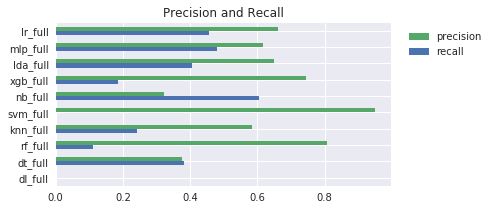

In [8]:
metrics = [evaluation.load_model_metrics(f, COUNTRY) for f in models]
results = visualize.display_model_comparison(metrics, 
                                             show_roc=False, 
                                             show_cm=False, 
                                             show_pov_rate_error=True, 
                                             highlight_best=True, 
                                             transpose=True, 
                                             rank_order=True)
visualize.display_precision_recall(results)

With the full feature set, the baseline Logistic Regression model remains at the top. The recall is still rather low, though. The MLP model achieves a much better recall while maintaining an average level of precision. 

The Deep Learning model in this case does not perform well without some type of class balancing.

# Model Results with Class Balancing, Tuning, CV, and Feature Selection <a class="anchor" id="all"></a>

Now let's look at the results of models when we included some sort of class balancing. This includes any oversampling, undersampling, or class weighting.

In [9]:
files = os.listdir(os.path.join(evaluation.MODELS_DIR, COUNTRY))
models = [f[:-4] for f in files if f[-4:] == '.pkl']
models = [f for f in models if 'simple' not in f]
models = [f for f in models if (('oversample' in f) or 
                                ('undersample' in f) or 
                                ('classwts' in f))]

# only include models from prior notebooks
models = [f for allowed in allowed_models for f in models if allowed in f]

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa,pov_rate_error,mean_rank
mlp_full_undersample_cv,0.857694,0.854518,0.44028,0.581136,0.308514,0.932805,0.481756,0.108348,9.25
xgb_full_undersample_cv,0.835837,0.87632,0.403156,0.552247,0.366854,0.928831,0.453724,0.139476,10.125
lr_full_oversample,0.854459,0.843033,0.433238,0.572346,0.344135,0.926334,0.473514,0.107608,10.625
lr_full_undersample,0.830133,0.883593,0.394889,0.545836,0.392892,0.926233,0.44493,0.141912,11.875
lr_full_oversample_cv,0.851611,0.838116,0.427456,0.566159,0.348544,0.925356,0.471316,0.107453,12.125
lr_full_classwts,0.830513,0.866754,0.39387,0.541618,0.384733,0.923196,0.428159,0.137116,12.875
svm_full_oversample,0.867253,0.755508,0.455099,0.568031,0.305525,0.909297,0.454544,0.0748775,13.875
rf_full_undersample_cv_ada,0.818561,0.904739,0.380136,0.535342,0.530756,0.928685,0.419727,0.152047,13.875
rf_full_classwts,0.894672,0.550596,0.543572,0.547061,0.285334,0.904138,0.482144,0.0276643,14.625
lda_full_oversample,0.815948,0.8906,0.375087,0.52786,0.424324,0.921219,0.408593,0.151802,14.75


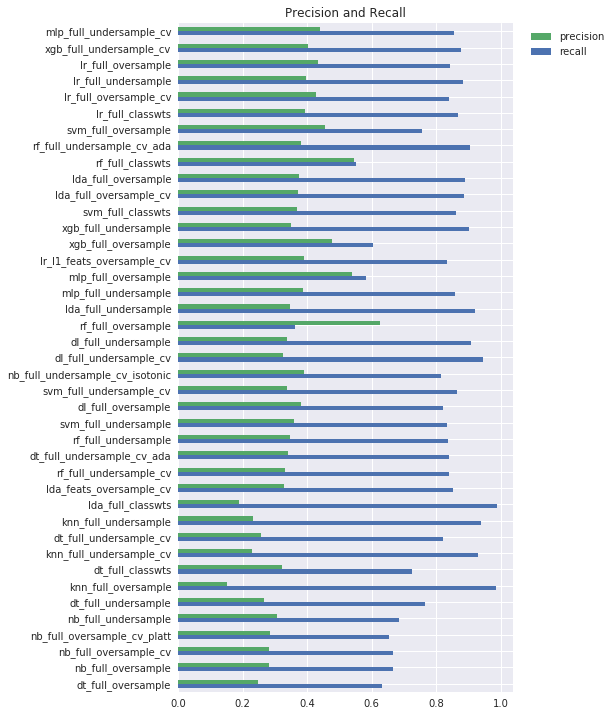

In [10]:
metrics = [evaluation.load_model_metrics(f, COUNTRY) for f in models]
results = visualize.display_model_comparison(metrics, 
                                             show_roc=False, 
                                             show_cm=False, 
                                             show_pov_rate_error=True, 
                                             highlight_best=True, 
                                             transpose=True, 
                                             rank_order=True)
visualize.display_precision_recall(results)

In [11]:
results.to_csv(Path('..', 'data', 'processed', COUNTRY, 'idn-master-results.csv'), index_label='name')

By balancing the dataset, we achieve a much higher recall rate for most algorithms, though this has a significant diminishing effect on the precision. If our goal is to accurately identify the highest percentage of `poor` households, this tradeoff could be acceptable. 

Interestingly, the baseline Logistic Regression model appears to rise to the top. However, the MLP model and several others are comparable and achieve higher recall. 

Let's inspect the feature ranks for these models

In [12]:
feats = evaluation.load_feats(models, COUNTRY)
feat_rankings = visualize.display_feat_ranks(feats);

,dt_full_classwts,dt_full_oversample,dt_full_undersample,dt_full_undersample_cv,dt_full_undersample_cv_ada,lda_feats_oversample_cv,lda_full_classwts,lda_full_oversample,lda_full_oversample_cv,lda_full_undersample,lr_full_oversample,lr_full_oversample_cv,lr_full_undersample,lr_l1_feats_oversample_cv,rf_full_classwts,rf_full_oversample,rf_full_undersample,rf_full_undersample_cv,rf_full_undersample_cv_ada,xgb_full_oversample,xgb_full_undersample,xgb_full_undersample_cv,mean_rank,count
der_hhsize,2,2,2,2,2,1,16,7,13,26,1,1,1,1,1,1,1,1,1,1,1,2,3.90909,22
hld_nbcell,6,10,7,6,13,3,38,47,47,52,10,18,10,4,7,8,8,5,9,9.5,3,6,14.8409,22
der_nchild10under,23,4,11,25,5,42,32,50,44,30,2,2,2,35,4,5,5,7,3,3,4,5,15.5909,22
cons_292__Yes,3,36,6,3,6,2,54,46,48,46,7,6,16,7,6,9,9,9,12,27,7.5,48,18.7955,22
geo_province__Central Java,33,25,20,11,19,nan,20,24,16,12,6,8,4,2,52,54,54,41,17,2,5,22,21.2857,21
geo_district,4,18,3,5,1,nan,1,1,1,1,87,46,262,44,3,3,3,10,2,4,2,1,23.9048,21
hld_cooking__Firewood,1,1,1,1,8,4,6,34,31,29,72,81,57,33,5,2,2,2,28,5,33.5,97,24.25,22
der_nliterate,28,30,26,24,9,nan,39,56,56,60,23,36,23,15,11,12,12,12,6,79.5,47.5,8,29.1905,21
der_nfemalesover10,22,14,42,243.5,22,nan,35,53,49,39,4,4,3,45,12,14,14,15,7,6,22,9,32.119,21
cons_266__Yes,16,8,24,9,29,7,113,77,75,82,46,53,45,11,13,11,11,11,18,15,7.5,79.5,34.5909,22


Like in the Malawi dataset, features such as the household size and number of cellphones appear to be strong predictive features.

Once again, let's filter the top 50 consumables by rank.

In [13]:
cons_feats = feat_rankings[feat_rankings.index.str.contains('cons')]['mean_rank'].iloc[0:50]
print("Top {} consumables features:".format(len(cons_feats)))
cons_feats_top50 = cons_feats.copy()
cons_feats.index = cons_feats.index.map(lambda x: questions[x.split('__')[0]])
cons_feats

Top 50 consumables features:


Gasoline/pertamax                                      18.795455
Clothes maintenance material                           34.590909
Clove filter cigarettes                                35.761905
Transport expenses                                     37.904762
Lubricant                                              39.431818
Broiler egg                                            40.750000
Other drinks (coffee, milk, etc)                       41.750000
A plate of rice accompanied by a mixture of dishes     43.619048
Expenses on gasoline                                   52.190476
Ready-made clothes for women                           52.272727
Ready-made clothes for men                             57.386364
Broiler meat                                           57.431818
Noodle (with meatball/boiled/fried)                    58.159091
Powdered/bean coffee                                   58.690476
Instant noodle                                         58.880952
Soya sauce               

Unlike Malawi, it appears that some of the strongest consumable features are not food items, but items such as transportation, cigarettes, and clothes.

In [14]:
feat_rankings = []
for key, value in sorted(feats.items()):
    if type(value) == pd.DataFrame:
        if 'coef' in value.columns:
            ranks = (pd.DataFrame(value['coef'].rename(key)))
            feat_rankings.append(ranks)
feat_rankings = pd.concat(feat_rankings, axis=1)
feat_rankings = feat_rankings.loc[cons_feats_top50.index]
feat_rankings.index = feat_rankings.index.map(lambda x: questions[x.split('__')[0]])
feat_rankings[~feat_rankings[feat_rankings > 0].sum(axis=1).apply(pd.isnull)]


,lda_feats_oversample_cv,lda_full_classwts,lda_full_oversample,lda_full_oversample_cv,lda_full_undersample,lr_full_oversample,lr_full_oversample_cv,lr_full_undersample,lr_l1_feats_oversample_cv
Gasoline/pertamax,-1.299877,-0.513682,-0.895837,-0.850055,-0.818215,-1.129747,-1.195697,-0.639122,-0.777934
Clothes maintenance material,-0.748145,-0.172630,-0.401325,-0.412460,-0.341821,-0.526372,-0.533085,-0.419294,-0.667107
Clove filter cigarettes,NaN,-0.669859,-0.860981,-0.879850,-0.814800,-1.136267,-1.126216,-1.075144,-0.889519
Transport expenses,NaN,-0.343418,-0.448921,-0.458789,-0.428740,-0.577996,-0.550488,-0.493887,-0.363262
Lubricant,-0.420980,-0.140143,-0.294182,-0.298031,-0.313241,-0.458113,-0.434158,-0.607980,-0.337744
Broiler egg,-0.568623,-0.428689,-0.548541,-0.540783,-0.521291,-0.463687,-0.438069,-0.416434,-0.281553
"Other drinks (coffee, milk, etc)",-0.654570,-0.340289,-0.476689,-0.448543,-0.308854,-0.425302,-0.397329,-0.417699,-0.486088
A plate of rice accompanied by a mixture of dishes,NaN,-0.525086,-0.821862,-0.845792,-0.723975,-0.995948,-1.044576,-0.697462,-0.862400
Expenses on gasoline,NaN,-0.310331,-0.327991,-0.293998,-0.215751,-0.250695,-0.226408,-0.346025,-0.436651
Ready-made clothes for women,-0.701638,-0.177276,-0.324817,-0.329469,-0.314260,-0.544311,-0.523177,-0.372254,-0.668213


Also like the Malawi dataset, there are only a few items that consistently seem to have a positive correlation with poverty.

# Indonesia Summary <a class="anchor" id="summary"></a>

The model results above demonstrate the differences in the Malawi and Indonesia datasets, and especially the impact of having an unbalanced dataset on the model performance.